In [2]:
# Cell 1: Setup and Importsimport os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, roc_auc_score, RocCurveDisplay

# Paths (adjust if needed)
data_path = "/Users/terrylin/Desktop/Thesis/Two-Stage-Network-Prediction/dataset_for_drl.csv"  # replace with your real path
output_dir = "/Users/terrylin/Desktop/Thesis/Two-Stage-Network-Prediction/project/results"
signal_model_path = os.path.join(output_dir, "random_forest_signal.pkl")
rf_model_path = os.path.join(output_dir, "random_forest_loss.pkl")
logistic_model_path = os.path.join(output_dir, "logistic_regression_loss.pkl")

In [3]:
# Cell 2: Load Data
print("Loading dataset...")
df = pd.read_csv(data_path)
df = df[(df['losses'] >= 1) & (df['losses'] <= 40)].copy()
print(f"Dataset shape: {df.shape}")
df.head()

Loading dataset...
Dataset shape: (195929, 35)


,users,fps,antenna,scenario,duplication,deadline,time,losses,north,east,...,temp,heading,lat,lon,dist_1,dist_2,rx_bitrate,tx_bitrate,signal,bandwidth
8,n1,1fps,2x2,aldrich,nodup,0.020,1.5,10.0,33.645114,-117.842182,...,5558.0,47.0,4.680264e+06,-3.596322e+06,14.820685,17.475177,433.3,866.7,-51,80
10,n1,1fps,2x2,aldrich,nodup,0.015,1.5,10.0,33.645114,-117.842182,...,5558.0,47.0,4.680264e+06,-3.596322e+06,14.820685,17.475177,433.3,866.7,-51,80
12,n1,1fps,2x2,aldrich,nodup,0.030,1.5,10.0,33.645114,-117.842182,...,5558.0,47.0,4.680264e+06,-3.596322e+06,14.820685,17.475177,433.3,866.7,-51,80
14,n1,1fps,2x2,aldrich,nodup,0.010,1.5,10.0,33.645114,-117.842182,...,5558.0,47.0,4.680264e+06,-3.596322e+06,14.820685,17.475177,433.3,866.7,-51,80
16,n1,1fps,2x2,aldrich,nodup,0.020,2.5,10.0,33.645115,-117.842183,...,5558.0,47.0,4.680264e+06,-3.596322e+06,14.883996,17.460039,433.3,780.0,-45,80


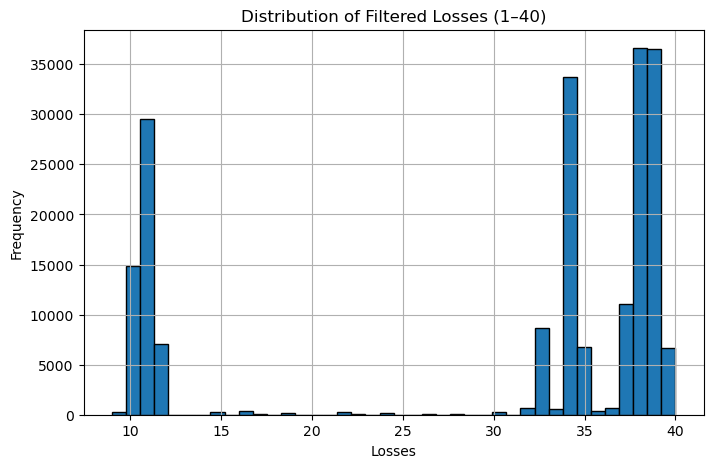

In [4]:
# Cell 3: Visualize Original Loss Distribution
plt.figure(figsize=(8, 5))
df['losses'].hist(bins=40, edgecolor='black')
plt.title("Distribution of Filtered Losses (1–40)")
plt.xlabel("Losses")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [5]:
# Cell 4: Load Trained Models
print("Loading trained models...")
signal_model = joblib.load(signal_model_path)
rf_model = joblib.load(rf_model_path)
logistic_model = joblib.load(logistic_model_path)
print("Models loaded.")

Loading trained models...
Models loaded.


In [6]:
# Cell 5: Predict Signal
sample_df = df[['dist_1', 'dist_2', 'signal']].copy()
signal_preds = signal_model.predict(sample_df)
print(f"Signal predictions (first 5): {signal_preds[:5]}")

Signal predictions (first 5): [-51. -51. -51. -51. -45.]


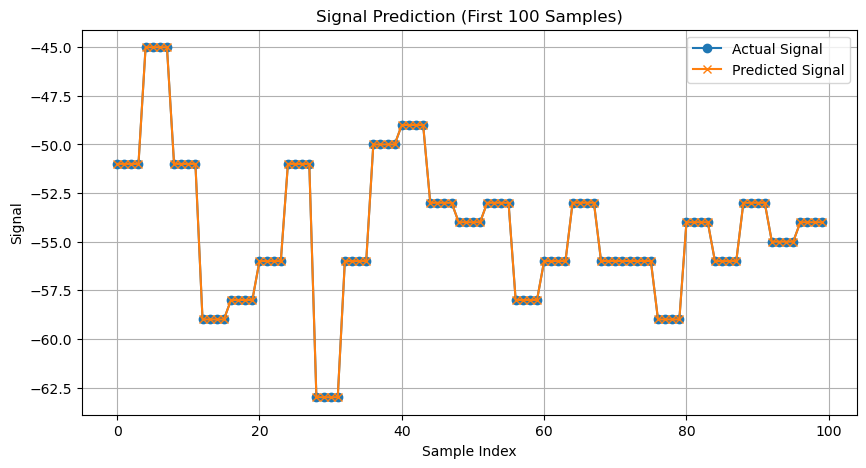

In [7]:
# Cell 6: Visualize Signal Predictions vs Actual
plt.figure(figsize=(10, 5))
plt.plot(df['signal'].values[:100], label='Actual Signal', marker='o')
plt.plot(signal_preds[:100], label='Predicted Signal', marker='x')
plt.title("Signal Prediction (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Cell 7: Predict Loss Probabilities
sample_df['predicted_signal'] = signal_preds
sample_df = sample_df.dropna(subset=['dist_1', 'dist_2', 'predicted_signal']).reset_index(drop=True)

rf_probs = rf_model.predict_proba(sample_df[['dist_1', 'dist_2', 'predicted_signal']])[:, 1]
logistic_probs = logistic_model.predict_proba(sample_df[['dist_1', 'dist_2', 'predicted_signal']])[:, 1]


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Cell 8: Visualize ROC Curve (Optional if true labels exist)
if 'loss_th_25_next' in df.columns:
    RocCurveDisplay.from_predictions(df['loss_th_25_next'], logistic_probs, name='Logistic')
    RocCurveDisplay.from_predictions(df['loss_th_25_next'], rf_probs, name='Random Forest')
    plt.title("ROC Curve Comparison")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Cell 9: Compare Probabilities
plt.figure(figsize=(10, 5))
plt.plot(logistic_probs[:100], label='Logistic Prob', alpha=0.7)
plt.plot(rf_probs[:100], label='RF Prob', alpha=0.7)
plt.title("Loss Exceeding Threshold Probability (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Cell 10: Conclusion Summary
print("This notebook demonstrates how to:")
print("1. Load trained models for signal and loss prediction")
print("2. Predict future signal values")
print("3. Predict the probability of high packet loss")
print("4. Visualize model predictions and metrics")